### Configuration: number of files and ServiceX usage

In [1]:
# GLOBAL CONFIGURATION
N_FILES_MAX_PER_SAMPLE = 1  # input files per process, set to -1 for no limit / 1 or 10 for quick debugging
USE_SERVICEX = False
USE_DASK = True
SERVICEX_IGNORE_CACHE = False  # set to True to force re-running of transforms
AF = "local"  # set to "coffea_casa" for coffea-casa environments, "EAF" for FNAL, "local" for local setups

### relevant imports

In [2]:
import asyncio
import time

import awkward as ak
import vector
from coffea import processor
from coffea.processor import servicex
import hist
import json
import numpy as np
import uproot
import cabinetry
from func_adl_servicex import ServiceXSourceUpROOT
from func_adl import ObjectStream
from servicex import ServiceXDataset
from coffea.nanoevents.schemas.base import BaseSchema
import matplotlib.pyplot as plt

import utils

vector.register_awkward()

### coffea Processor

In [3]:
processor_base = processor.ProcessorABC if not USE_SERVICEX else servicex.Analysis

class TtbarAnalysis(processor_base):
    def __init__(self):
        num_bins = 25
        bin_low = 50
        bin_high = 550
        name = "observable"
        label = "observable [GeV]"
        self.hist = (
            hist.Hist.new.Reg(num_bins, bin_low, bin_high, name=name, label=label)
            .StrCat(["4j1b", "4j2b"], name="region", label="Region")
            .StrCat([], name="process", label="Process", growth=True)
            .StrCat([], name="variation", label="Systematic variation", growth=True)
            .Weight()
        )

    def process(self, events):
        histogram = self.hist.copy()

        process = events.metadata["process"]  # "ttbar" etc.
        variation = events.metadata["variation"]  # "nominal" etc.

        # normalization for MC
        x_sec = events.metadata["xsec"]
        nevts_total = events.metadata["nevts"]
        lumi = 3378 # /pb
        if process != "data":
            xsec_weight = x_sec * lumi / nevts_total
        else:
            xsec_weight = 1


        # very very loosely based on https://arxiv.org/abs/2006.13076

        # pT > 25 GeV for leptons & jets
        selected_electrons = events.electron[events.electron.pt > 25]
        selected_muons = events.muon[events.muon.pt > 25]
        selected_jets = events.jet[events.jet.pt > 25]  # pT > 25 GeV for jets

        # single lepton requirement
        event_filters = (ak.count(selected_electrons.pt, axis=1) & ak.count(selected_muons.pt, axis=1) == 1)
        # at least four jets
        event_filters = event_filters & (ak.count(selected_jets.pt, axis=1) >= 4)
        # at least one b-tagged jet ("tag" means score above threshold)
        B_TAG_THRESHOLD = 0.5
        event_filters = event_filters & (ak.sum(selected_jets.btag >= B_TAG_THRESHOLD, axis=1) >= 1)

        # apply event filters
        selected_events = events[event_filters]
        selected_electrons = selected_electrons[event_filters]
        selected_muons = selected_muons[event_filters]
        selected_jets = selected_jets[event_filters]

        for region in ["4j1b", "4j2b"]:
            # further filtering: 4j1b CR with single b-tag, 4j2b SR with two or more tags
            if region == "4j1b":
                region_filter = ak.sum(selected_jets.btag >= B_TAG_THRESHOLD, axis=1) == 1
                selected_jets_region = selected_jets[region_filter]
                # use HT (scalar sum of jet pT) as observable
                observable = ak.sum(selected_jets_region.pt, axis=-1)
        
            elif region == "4j2b":
                region_filter = ak.sum(selected_jets.btag > B_TAG_THRESHOLD, axis=1) >= 2
                selected_jets_region = selected_jets[region_filter]
                
                if USE_SERVICEX:
                    # wrap into a four-vector object to allow addition
                    selected_jets_region = ak.zip(
                        {
                        "px": selected_jets_region.px, "py": selected_jets_region.py, "pz": selected_jets_region.pz,
                        "E": selected_jets_region.e, "btag": selected_jets_region.btag,
                        },
                        with_name="Momentum4D",
                    )
                
                # reconstruct hadronic top as bjj system with largest pT
                trijet = ak.combinations(selected_jets_region, 3, fields=["j1", "j2", "j3"])  # trijet candidates
                trijet["p4"] = trijet.j1 + trijet.j2 + trijet.j3  # calculate four-momentum of tri-jet system
                trijet["max_btag"] = np.maximum(trijet.j1.btag, np.maximum(trijet.j2.btag, trijet.j3.btag))
                trijet = trijet[trijet.max_btag > B_TAG_THRESHOLD]  # require at least one-btag in trijet candidates
                # pick trijet candidate with largest pT and calculate mass of system
                trijet_mass = trijet["p4"][ak.argmax(trijet.p4.pt, axis=1, keepdims=True)].mass
                observable = ak.flatten(trijet_mass)

            histogram.fill(
                observable=observable, region=region, process=process, variation=variation, weight=xsec_weight
            )

        output = {"nevents": {events.metadata["dataset"]: len(events)}, "hist": histogram}

        return output

    def postprocess(self, accumulator):
        return accumulator

### AGC schema (for pure coffea)

In [4]:
from coffea.nanoevents.schemas.base import BaseSchema, zip_forms
from coffea.nanoevents.methods import base, vector
from coffea.nanoevents import transforms


# https://github.com/mat-adamec/agc_coffea/blob/main/agc_schema.py
class AGCSchema(BaseSchema):
    def __init__(self, base_form):
        super().__init__(base_form)
        self._form["contents"] = self._build_collections(self._form["contents"])

    def _build_collections(self, branch_forms):
        names = set([k.split('_')[0] for k in branch_forms.keys() if not (k.startswith('number'))])
        # Remove n(names) from consideration. It's safe to just remove names that start with n, as nothing else begins with n in our fields.
        # Also remove GenPart, PV and MET because they deviate from the pattern of having a 'number' field.
        names = [k for k in names if not (k.startswith('n') | k.startswith('met') | k.startswith('GenPart') | k.startswith('PV'))]
        output = {}
        for name in names:
            offsets = transforms.counts2offsets_form(branch_forms['number' + name])
            content = {k[len(name)+1:]: branch_forms[k] for k in branch_forms if (k.startswith(name + "_") & (k[len(name)+1:] != 'e'))}
            # Add energy separately so its treated correctly by the p4 vector.
            content['energy'] = branch_forms[name+'_e']
            # Check for LorentzVector
            output[name] = zip_forms(content, name, 'PtEtaPhiELorentzVector', offsets=offsets)

        # Handle GenPart, PV, MET. Note that all the nPV_*'s should be the same. We just use one.
        output['met'] = zip_forms({k[len('met')+1:]: branch_forms[k] for k in branch_forms if k.startswith('met_')}, 'met')
        #output['GenPart'] = zip_forms({k[len('GenPart')+1:]: branch_forms[k] for k in branch_forms if k.startswith('GenPart_')}, 'GenPart', offsets=transforms.counts2offsets_form(branch_forms['numGenPart']))
        output['PV'] = zip_forms({k[len('PV')+1:]: branch_forms[k] for k in branch_forms if (k.startswith('PV_') & ('npvs' not in k))}, 'PV', offsets=transforms.counts2offsets_form(branch_forms['nPV_x']))
        return output

    @property
    def behavior(self):
        behavior = {}
        behavior.update(base.behavior)
        behavior.update(vector.behavior)
        return behavior

### metadata & fileset construction

In [5]:
fileset = utils.construct_fileset(N_FILES_MAX_PER_SAMPLE, use_xcache=False)

print(f"processes in fileset: {list(fileset.keys())}")
print(f"\nexample of information in fileset:\n{{\n  'files': [{fileset['ttbar__nominal']['files'][0]}, ...],")
print(f"  'metadata': {fileset['ttbar__nominal']['metadata']}\n}}")

processes in fileset: ['ttbar__nominal', 'ttbar__scaledown', 'ttbar__scaleup', 'ttbar__ME_var', 'ttbar__PS_var', 'single_top_s_chan__nominal', 'single_top_t_chan__nominal', 'single_top_tW__nominal', 'wjets__nominal']

example of information in fileset:
{
  'files': [https://xrootd-local.unl.edu:1094//store/user/AGC/datasets/RunIIFall15MiniAODv2/TT_TuneCUETP8M1_13TeV-powheg-pythia8/MINIAODSIM//PU25nsData2015v1_76X_mcRun2_asymptotic_v12_ext3-v1/00000/00DF0A73-17C2-E511-B086-E41D2D08DE30.root, ...],
  'metadata': {'process': 'ttbar', 'variation': 'nominal', 'nevts': 41812, 'xsec': 729.84}
}


### ServiceX-specific functionality: datasource construction, query, asyncio
(move to utils file)

In [6]:
def make_datasource(fileset:dict, name: str, query: ObjectStream, ignore_cache: bool):
    """Creates a ServiceX datasource for a particular ATLAS Open data file."""
    datasets = [ServiceXDataset(fileset[name]["files"], backend_name="uproot", ignore_cache=ignore_cache)]
    return servicex.DataSource(
        query=query, metadata=fileset[name]["metadata"], datasets=datasets
    )

def get_query(source: ObjectStream) -> ObjectStream:
    """Query for event / column selection: no filter, select all columns
    """
    return source.Select(lambda e: {
                                    "electron_e": e.electron_e,
                                    "electron_pt": e.electron_pt,
                                    "electron_px": e.electron_px,
                                    "electron_py": e.electron_py,
                                    "electron_pz": e.electron_pz,
                                    "electron_eta": e.electron_eta,
                                    "electron_phi": e.electron_phi,
                                    "electron_ch": e.electron_ch,
                                    "electron_iso": e.electron_iso,
                                    "electron_isLoose": e.electron_isLoose,
                                    "electron_isMedium": e.electron_isMedium,
                                    "electron_isTight": e.electron_isTight,
                                    "electron_dxy": e.electron_dxy,
                                    "electron_dz": e.electron_dz,
                                    "electron_dxyError": e.electron_dxyError,
                                    "electron_dzError": e.electron_dzError,

                                    "muon_e": e.muon_e,
                                    "muon_pt": e.muon_pt,
                                    "muon_px": e.muon_px,
                                    "muon_py": e.muon_py,
                                    "muon_pz": e.muon_pz,
                                    "muon_eta": e.muon_eta,
                                    "muon_phi": e.muon_phi,
                                    "muon_ch": e.muon_ch,
                                    "muon_isSoft": e.muon_isSoft,
                                    "muon_isTight": e.muon_isTight,
                                    "muon_dxy": e.muon_dxy,
                                    "muon_dz": e.muon_dz,
                                    "muon_dxyError": e.muon_dxyError,
                                    "muon_dzError": e.muon_dzError,
                                    "muon_pfreliso03all": e.muon_pfreliso03all,
                                    "muon_pfreliso04all": e.muon_pfreliso04all,
                                    "muon_jetidx": e.muon_jetidx,
                                    "muon_genpartidx": e.muon_genpartidx,

                                    "jet_e": e.jet_e,
                                    "jet_pt": e.jet_pt,
                                    "jet_px": e.jet_px,
                                    "jet_py": e.jet_py,
                                    "jet_pz": e.jet_pz,
                                    "jet_eta": e.jet_eta,
                                    "jet_phi": e.jet_phi,
                                    "jet_ch": e.jet_ch,
                                    "jet_mass": e.jet_mass,
                                    "jet_btag": e.jet_btag,
                                    "jet_pt_uncorr": e.jet_pt_uncorr
                                   }
                        )


async def produce_all_histograms(fileset, use_dask=False):
    """Runs the histogram production, processing input files with ServiceX and
    producing histograms with coffea.
    """
    # create the query
    ds = ServiceXSourceUpROOT("cernopendata://dummy", "events", backend_name="uproot")
    ds.return_qastle = True
    data_query = get_query(ds)

    # EXECUTOR: local vs Dask
    if not use_dask:
        executor = servicex.LocalExecutor()
    else:
        executor = servicex.DaskExecutor(client_addr="tls://localhost:8786")

    datasources = [
        make_datasource(fileset, ds_name, data_query, ignore_cache=SERVICEX_IGNORE_CACHE)
        for ds_name in fileset.keys()
    ]

    # create the analysis processor
    analysis_processor = TtbarAnalysis()

    async def run_updates_stream(accumulator_stream, name):
        """Run to get the last item in the stream"""
        coffea_info = None
        try:
            async for coffea_info in accumulator_stream:
                pass
        except Exception as e:
            raise Exception(f"Failure while processing {name}") from e
        return coffea_info

    all_histogram_dicts = await asyncio.gather(
        *[
            run_updates_stream(
                executor.execute(analysis_processor, source),
                f"{source.metadata['process']}__{source.metadata['variation']}",
            )
            for source in datasources
        ]
    )
    all_histograms = sum([h["hist"] for h in all_histogram_dicts])
    
    return all_histograms

### via servicex-databinder (separate ServiceX + coffea)

In [7]:
from servicex_databinder import DataBinder
query_string = """Select(lambda e: {
                    'electron_e': e.electron_e,
                    'electron_pt': e.electron_pt,
                    'electron_px': e.electron_px,
                    'electron_py': e.electron_py,
                    'electron_pz': e.electron_pz,
                    'electron_eta': e.electron_eta,
                    'electron_phi': e.electron_phi,
                    'electron_ch': e.electron_ch,
                    'electron_iso': e.electron_iso,
                    'electron_isLoose': e.electron_isLoose,
                    'electron_isMedium': e.electron_isMedium,
                    'electron_isTight': e.electron_isTight,
                    'electron_dxy': e.electron_dxy,
                    'electron_dz': e.electron_dz,
                    'electron_dxyError': e.electron_dxyError,
                    'electron_dzError': e.electron_dzError,

                    'muon_e': e.muon_e,
                    'muon_pt': e.muon_pt,
                    'muon_px': e.muon_px,
                    'muon_py': e.muon_py,
                    'muon_pz': e.muon_pz,
                    'muon_eta': e.muon_eta,
                    'muon_phi': e.muon_phi,
                    'muon_ch': e.muon_ch,
                    'muon_isSoft': e.muon_isSoft,
                    'muon_isTight': e.muon_isTight,
                    'muon_dxy': e.muon_dxy,
                    'muon_dz': e.muon_dz,
                    'muon_dxyError': e.muon_dxyError,
                    'muon_dzError': e.muon_dzError,
                    'muon_pfreliso03all': e.muon_pfreliso03all,
                    'muon_pfreliso04all': e.muon_pfreliso04all,
                    'muon_jetidx': e.muon_jetidx,
                    'muon_genpartidx': e.muon_genpartidx,

                    'jet_e': e.jet_e,
                    'jet_pt': e.jet_pt,
                    'jet_px': e.jet_px,
                    'jet_py': e.jet_py,
                    'jet_pz': e.jet_pz,
                    'jet_eta': e.jet_eta,
                    'jet_phi': e.jet_phi,
                    'jet_ch': e.jet_ch,
                    'jet_mass': e.jet_mass,
                    'jet_btag': e.jet_btag,
                    'jet_pt_uncorr': e.jet_pt_uncorr})"""

# from servicex_databinder import DataBinder

databinder_config = {"General": {"ServiceXBackendName": "uproot",
                                 "OutputDirectory": "outputs",
                                 "OutputFormat": "parquet",
                                 "IgnoreServiceXCache": True},
                     "Sample": [
                         {
                             "Name": "single_top_s_chan__nominal",
                             "RucioDID": "user.ivukotic:user.ivukotic.single_top_s_chan__nominal",
                             "Tree": "events",
                             "FuncADL": query_string
                         }
                     ]
                    }

# sx_db = DataBinder(databinder_config)
# out = sx_db.deliver()

# update list of fileset files, pointing to ServiceX output
# for process in fileset.keys():
#     fileset[process]["files"] = out[process]["events"]

### execute

In [8]:
t0 = time.time()

if USE_SERVICEX:
    # in a notebook:
    all_histograms = await produce_all_histograms(fileset, use_dask=USE_DASK)

    # as a script:
    # async def produce_all_the_histograms(fileset, use_dask=use_dask):
    #    return await produce_all_histograms(fileset, use_dask=use_dask)
    #
    # all_histograms = asyncio.run(produce_all_the_histograms(fileset, use_dask=USE_DASK))

else:
    t0 = time.time()
    if USE_DASK:
        executor = processor.DaskExecutor(client=utils.get_client(AF))
    else:
        executor = processor.IterativeExecutor()

    run = processor.Runner(executor=executor, schema=AGCSchema, savemetrics=True, metadata_cache={})

    all_histograms, metrics = run(fileset, "events", processor_instance=TtbarAnalysis())
    all_histograms = all_histograms["hist"]
    
print(f"\nexecution took {time.time() - t0:.2f} seconds")

[########################################] | 100% Completed | 19.9s
execution took 24.49 seconds


In [9]:
if not USE_SERVICEX:
    print(f"number of files processed: {metrics['chunks']}")
    print(f"data read: {metrics['bytesread']/1024**2:.1f} MB")

    metrics

number of files processed: 9
data read: 1.2 MB


### plotting 

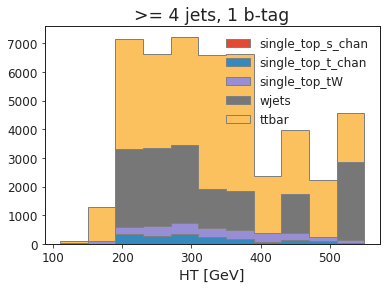

In [10]:
utils.set_style()

all_histograms[120j::hist.rebin(2), "4j1b", :, "nominal"].stack("process")[::-1].plot(stack=True, histtype="fill", linewidth=1, edgecolor="grey")
plt.legend(frameon=False)
plt.title(">= 4 jets, 1 b-tag")
plt.xlabel("HT [GeV]");

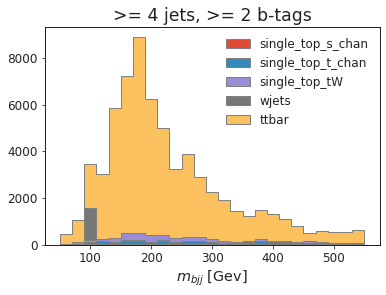

In [11]:
all_histograms[:, "4j2b", :, "nominal"].stack("process")[::-1].plot(stack=True, histtype="fill", linewidth=1,edgecolor="grey")
plt.legend(frameon=False)
plt.title(">= 4 jets, >= 2 b-tags");
plt.xlabel("$m_{bjj}$ [Gev]");

In [12]:
print("4j, >=2b", sum(all_histograms[:, "4j2b", "ttbar", "nominal"].values())) # total before splitting: 101790.4947274355
print("4j, 1b", sum(all_histograms[:, "4j1b", "ttbar", "nominal"].values()))

4j, >=2b 58787.030551994656
4j, 1b 29540.925081794707


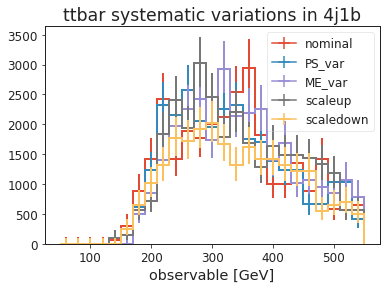

In [13]:
all_histograms[:, "4j1b", "ttbar", :].stack("variation").plot(linewidth=2)
plt.legend()
plt.title("ttbar systematic variations in 4j1b");

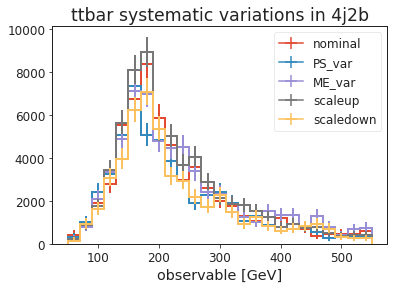

In [14]:
all_histograms[:, "4j2b", "ttbar", :].stack("variation").plot(linewidth=2)
plt.legend()
plt.title("ttbar systematic variations in 4j2b");

### saving histograms & cabinetry

In [15]:
with uproot.recreate("histograms.root") as f:
    for region in ["4j1b", "4j2b"]:
        f[f"{region}_ttbar"] = all_histograms[120j::hist.rebin(2), region, "ttbar", "nominal"]
        f[f"{region}_ttbar_ME_var"] = all_histograms[120j::hist.rebin(2), region, "ttbar", "ME_var"]
        f[f"{region}_ttbar_PS_var"] = all_histograms[120j::hist.rebin(2), region, "ttbar", "PS_var"]
        f[f"{region}_ttbar_scaledown"] = all_histograms[120j::hist.rebin(2), region, "ttbar", "scaledown"]
        f[f"{region}_ttbar_scaleup"] = all_histograms[120j::hist.rebin(2), region, "ttbar", "scaleup"]

        f[f"{region}_wjets"] = all_histograms[120j::hist.rebin(2), region, "wjets", "nominal"]
        f[f"{region}_single_top_s_chan"] = all_histograms[120j::hist.rebin(2), region, "single_top_s_chan", "nominal"]
        f[f"{region}_single_top_t_chan"] = all_histograms[120j::hist.rebin(2), region, "single_top_t_chan", "nominal"]
        f[f"{region}_single_top_tW"] = all_histograms[120j::hist.rebin(2), region, "single_top_tW", "nominal"]

WARNING - Control_region_ttbar_ME-variation_Up has empty bins: [0]
WARNING - Control_region_ttbar_scale-variation_Down has empty bins: [0]
WARNING - Control_region_W+jets has empty bins: [0 1 7 9]
WARNING - Control_region_single-top,-s-channel has empty bins: [10]
WARNING - Control_region_single-top,-t-channel has empty bins: [10]
WARNING - Signal_region_W+jets has empty bins: [ 0  1  2  3  4  5  6  7  8  9 10]
WARNING - Control_region_ttbar_ME-variation_Up has empty bins: [0]
WARNING - Control_region_ttbar_scale-variation_Down has empty bins: [0]
WARNING - Control_region_W+jets has empty bins: [0 1 7 9]
WARNING - Control_region_single-top,-s-channel has empty bins: [10]
WARNING - Control_region_single-top,-t-channel has empty bins: [10]
WARNING - Signal_region_W+jets has empty bins: [ 0  1  2  3  4  5  6  7  8  9 10]


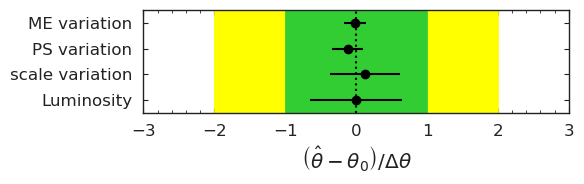

In [16]:
config = cabinetry.configuration.load("config.yml")
cabinetry.templates.collect(config)
cabinetry.templates.postprocess(config)  # optional post-processing (e.g. smoothing)
ws = cabinetry.workspace.build(config)

model, data = cabinetry.model_utils.model_and_data(ws)
fit_results = cabinetry.fit.fit(model, data)

cabinetry.visualize.pulls(
    fit_results, exclude="ttbar_norm", close_figure=True, save_figure=False
)


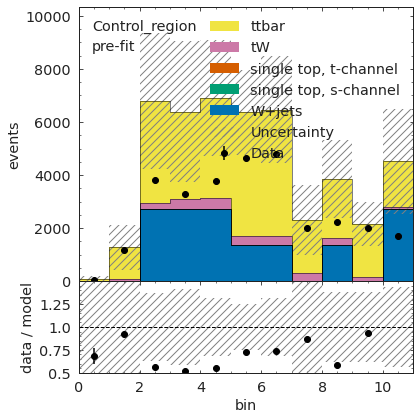

In [17]:
model_prediction = cabinetry.model_utils.prediction(model)
figs = cabinetry.visualize.data_mc(model_prediction, data, close_figure=True, log_scale=False)
figs[0]["figure"]

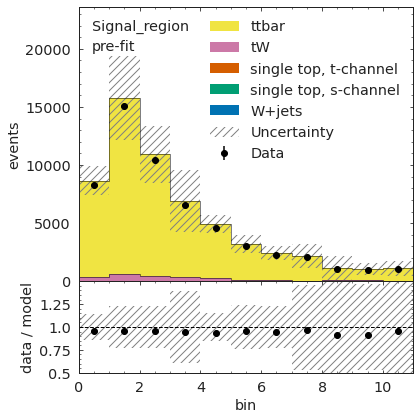

In [18]:
figs[1]["figure"]